In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os

In [2]:
#load data 
def load_data(data_dir):
    filepaths = []
    labels = []

    # get folders
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir,fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)
    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)


In [3]:
data_dir = r'C:\Deep Learning Projects\Lung-Cancer-Detection\lung_colon_image_set\lung_image_sets'
df = load_data(data_dir)
change_label_names(df,'labels')

In [5]:
df['labels'].unique()

array(['Lung_adenocarcinoma', 'Lung_benign_tissue',
       'Lung squamous_cell_carcinoma'], dtype=object)

In [4]:
df.head()

filepaths               labels
0  C:\Deep Learning Projects\Lung-Cancer-Detectio...  Lung_adenocarcinoma
1  C:\Deep Learning Projects\Lung-Cancer-Detectio...  Lung_adenocarcinoma
2  C:\Deep Learning Projects\Lung-Cancer-Detectio...  Lung_adenocarcinoma
3  C:\Deep Learning Projects\Lung-Cancer-Detectio...  Lung_adenocarcinoma
4  C:\Deep Learning Projects\Lung-Cancer-Detectio...  Lung_adenocarcinoma

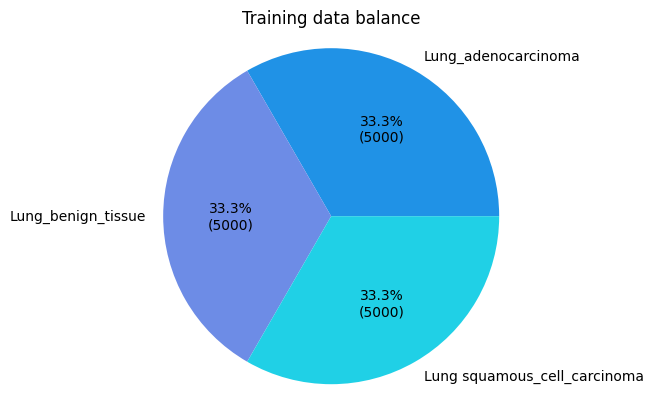

In [7]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train_df,ts_df = train_test_split(df,test_size=0.8,shuffle=True,random_state=42)
valid_df,test_df = train_test_split(ts_df,train_size=0.5,shuffle=True,random_state=42)

In [9]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [10]:
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. /255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths',y_col='labels',
                                       target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                       color_mode='rgb',shuffle=True)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths',y_col='labels',
                                       target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                       color_mode='rgb',shuffle=True)

test_gen = tr_gen.flow_from_dataframe(test_df, x_col='filepaths',y_col='labels',
                                       target_size=img_size, batch_size=batch_size, class_mode='categorical',
                                       color_mode='rgb',shuffle=True)

Found 3000 validated image filenames belonging to 3 classes.
Found 6000 validated image filenames belonging to 3 classes.
Found 6000 validated image filenames belonging to 3 classes.


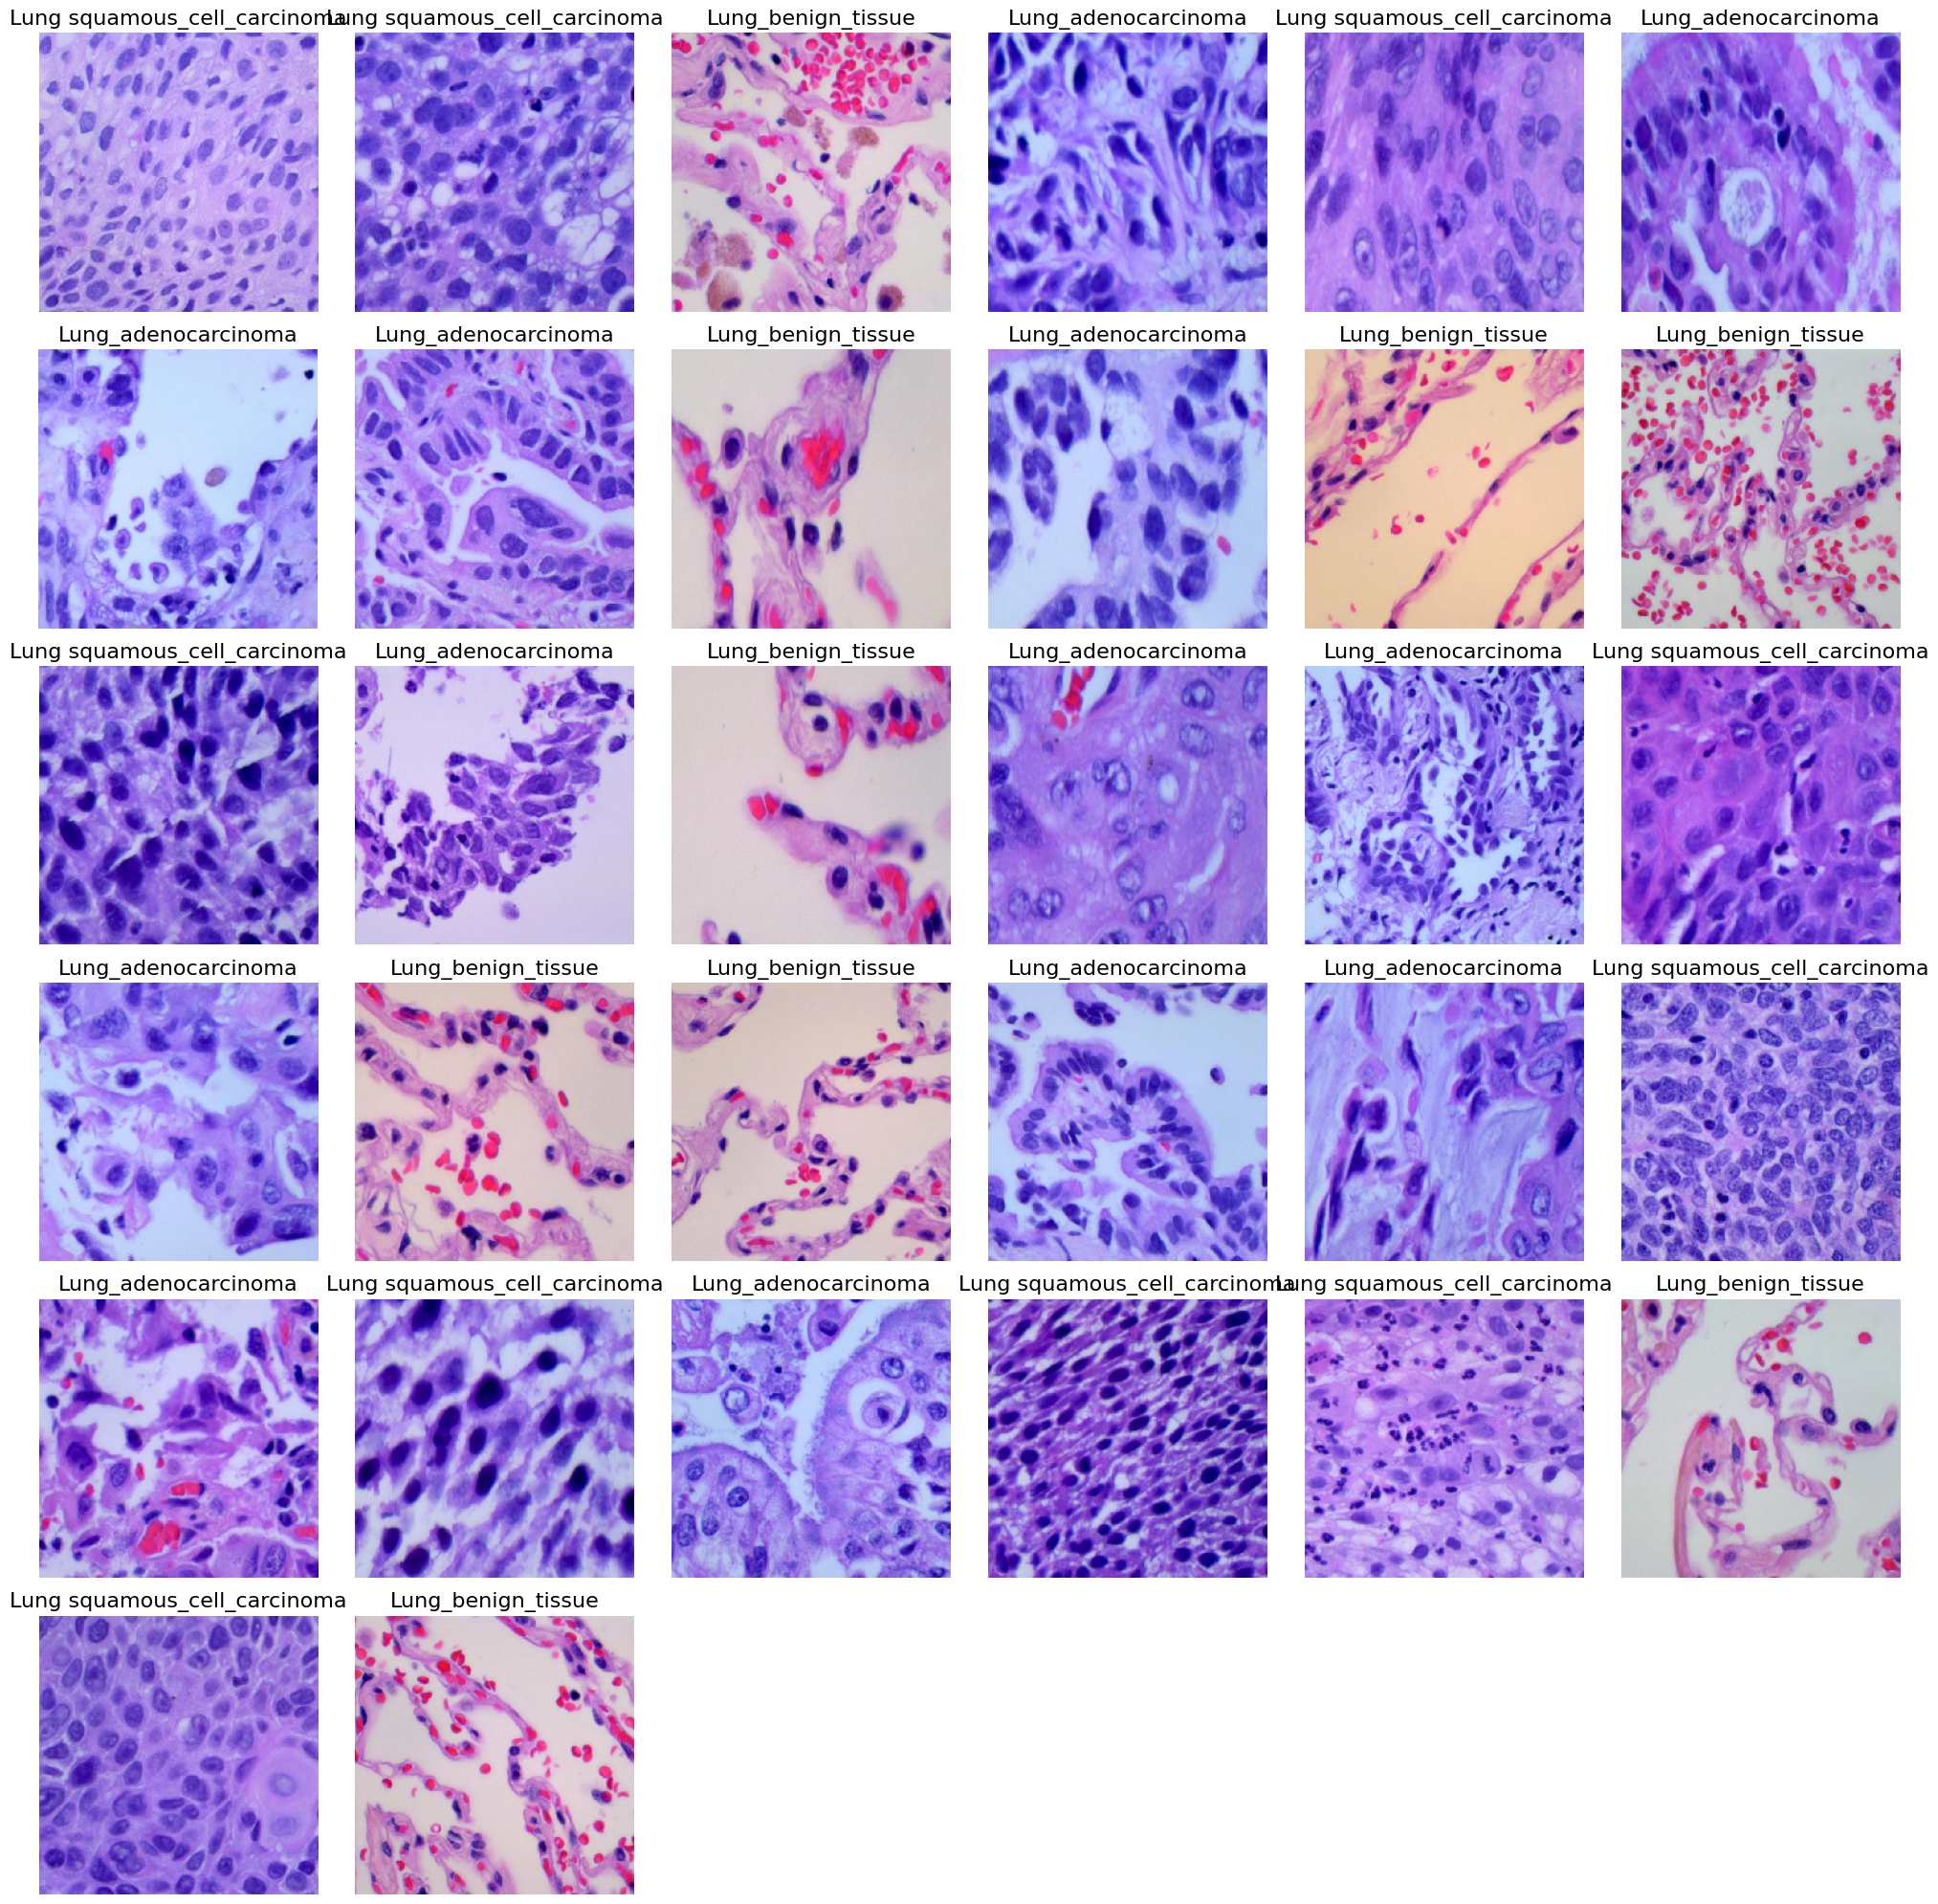

In [11]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import Sequential
# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [13]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys())) 

In [16]:

base_model = EfficientNetB3(weights='imagenet',
                            include_top=False,
                            input_shape = img_shape,
                            pooling=None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [17]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

In [18]:
epochs = 20
model = EfficientNetB3_model.fit(train_gen,
                                 epochs=epochs,
                                 verbose=1,
                                 validation_data=valid_gen,
                                 shuffle=False)

Epoch 1/20
 4/94 [>.............................] - ETA: 54:59 - loss: 1.3951 - accuracy: 0.3750

KeyboardInterrupt: 

In [19]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape = img_shape,
                            pooling=None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

In [20]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 
model = ResNet50_model.fit(train_gen,
                                 epochs=epochs,
                                 verbose=1,
                                 validation_data=valid_gen,
                                 shuffle=False)

Epoch 1/20
94/94 [==============================] - 793s 8s/step - loss: 0.5195 - accuracy: 0.7930 - val_loss: 1.6396 - val_accuracy: 0.3320
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9283

KeyboardInterrupt: 

In [22]:
model.save("pet_classifier_model.h5")  # Saves the model in HDF5 format

print(f"model saved to {'lung_classifier_model.h5'}")

NameError: name 'model' is not defined